# Selena's Test!

### Imports:

In [2]:
import fsspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter, AutoDateLocator,HourLocator,DayLocator
import numpy as np
import xarray as xr
from metpy.plots import USCOUNTIES
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.colors as colors
from pyproj import Proj
import seaborn as sns
sns.set()

#### Load in hourly Precip Data and calculate total for storm duration.

In [3]:
zarr_url = f's3://mdmf/gdp/stageiv_combined.zarr/'

fs2 = fsspec.filesystem('s3', anon=True, endpoint_url='https://usgs.osn.mghpcc.org/')

ds = xr.open_dataset(fs2.get_mapper(zarr_url), engine='zarr',

                             backend_kwargs={'consolidated':True}, chunks={})

ds = ds.sortby('time')

# Extract the relevant time range
start_time = '2006-09-16 12:00:00'
end_time = '2006-09-16 12:00:00'

precipitation_data = ds['Total_precipitation_surface_1_Hour_Accumulation'].sel(time=slice(start_time, end_time))

# Sum the precipitation values over the specified time range
total_precipitation = precipitation_data.sum(dim='time')

# Convert total_precipitation to inches
#conversion_factor = 0.0393701
#total_precipitation = total_precipitation * conversion_factor

np.max(total_precipitation)

<xarray.DataArray 'Total_precipitation_surface_1_Hour_Accumulation' ()> Size: 4B
dask.array<_nanmax_skip-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>

### Plot total precip for entire CONUS.

In [4]:
ds

<xarray.Dataset> Size: 758GB
Dimensions:                                          (time: 191948, y: 881,
                                                      x: 1121, time_bounds_1: 2)
Coordinates:
    lat                                              (x, y) float32 4MB dask.array<chunksize=(102, 80), meta=np.ndarray>
    lon                                              (x, y) float32 4MB dask.array<chunksize=(102, 80), meta=np.ndarray>
  * time                                             (time) datetime64[ns] 2MB ...
Dimensions without coordinates: y, x, time_bounds_1
Data variables:
    Total_precipitation_surface_1_Hour_Accumulation  (time, y, x) float32 758GB dask.array<chunksize=(1597, 80, 102), meta=np.ndarray>
    crs                                              int32 4B ...
    time_bounds                                      (time, time_bounds_1) datetime64[ns] 3MB dask.array<chunksize=(47987, 1), meta=np.ndarray>
Attributes: (12/34)
    Conventions:                          CF-1.4
    Generating_process_or_model:          River Forecast Center Quantitative ...
    Metadata_Conventions:                 Unidata Dataset Discovery v1.0
    Originating_or_generating_Center:     US National Weather Service, Nation...
    Originating_or_generating_Subcenter:  Environmental Modeling Center
    _CoordSysBuilder:                     ucar.nc2.dataset.conv.CF1Convention
    ...                                   ...
    processing_level:                     Aggregated .grib archive from the N...
    project:                              Various
    summary:                              Mosaicked into a national product a...
    time_coverage_end:                    present
    time_coverage_start:                  2002-01-01T00:00:00Z
    title:                                United States Stage IV Quantitative...

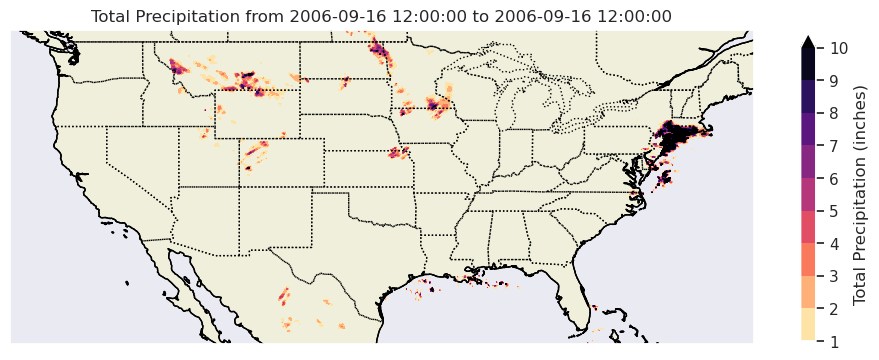

In [17]:
lon = ds['lon'].values
lat = ds['lat'].values

# Transpose the total_precipitation array if needed
total_precipitation = total_precipitation.transpose()

# Create a larger figure with Cartopy
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-128, -66.5, 24, 50], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black')

# Plot the total precipitation on the map
c = ax.contourf(lon, lat, total_precipitation, cmap='magma_r', levels=range(1, 11), extend='max', transform=ccrs.PlateCarree())
colorbar = plt.colorbar(c, ax=ax, label='Total Precipitation (inches)', shrink=0.5)  # Adjust the shrink parameter as needed

# Add title and labels
plt.title('Total Precipitation from {} to {}'.format(start_time, end_time))
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()


### Zoom in on NE CONUS.

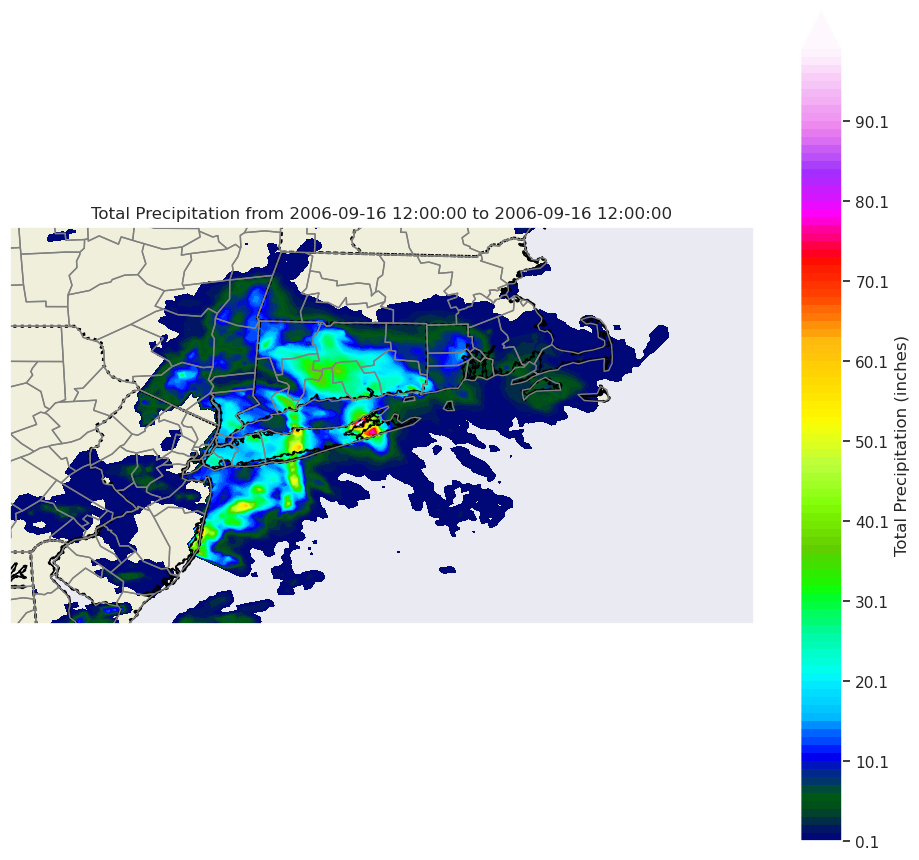

In [18]:
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-82, -66.5, 35, 48], crs=ccrs.PlateCarree())
ax.set_extent([-76, -68.5, 39, 43], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linestyle=':', linewidth=2)
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(USCOUNTIES,edgecolor='grey', linewidth=1)

# Plot the total precipitation on the map   (levels=range(1,10) OR WHAT I HAVE NOW
c = ax.contourf(lon, lat, total_precipitation, cmap='gist_ncar', levels=np.arange(0.1, 100, 1), extend='max', transform=ccrs.PlateCarree())
colorbar = plt.colorbar(c, ax=ax, label='Total Precipitation (inches)', shrink=0.9)  # Adjust the shrink parameter as needed

# Add title and labels
plt.title('Total Precipitation from {} to {}'.format(start_time, end_time))
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()